In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate import *
from model import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:352: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:427: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:452: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


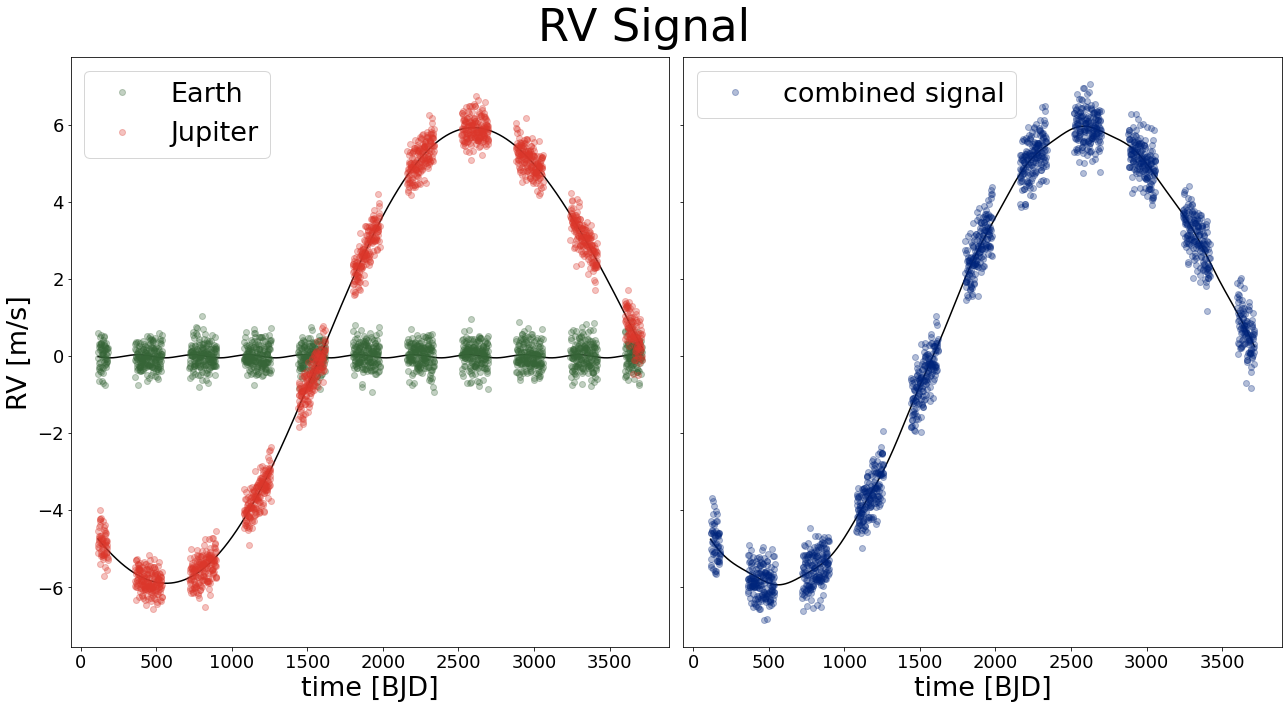

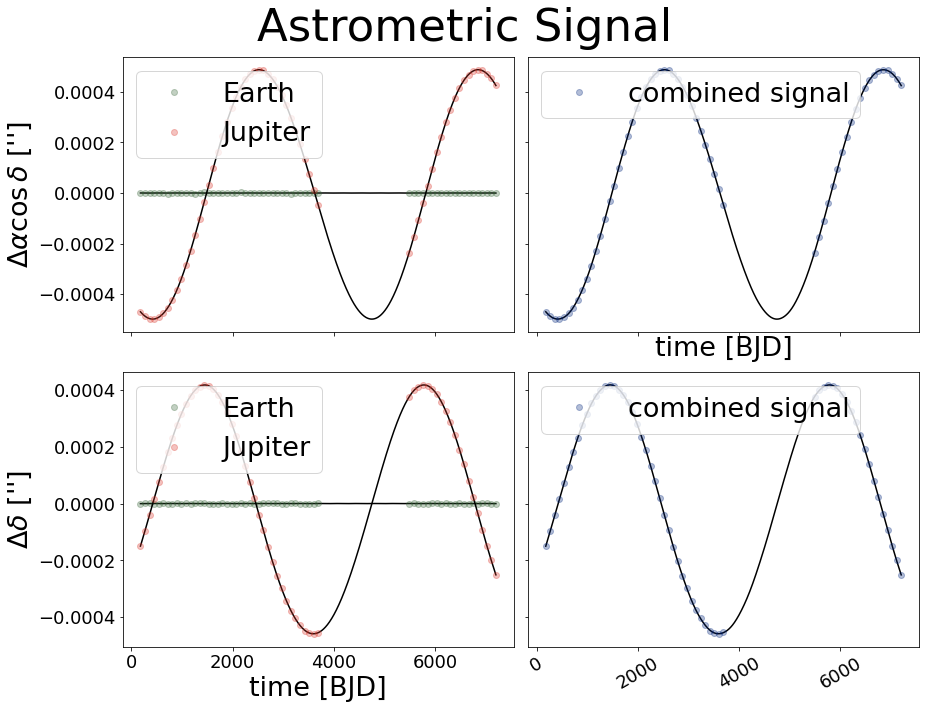

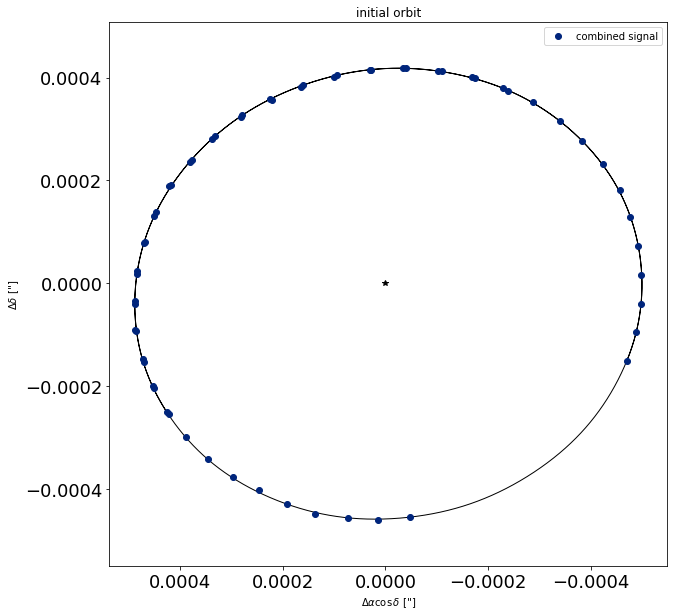

In [2]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(27.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+3600):
    if ii % 90 == 0:
        times_observed_astrometry.append(ii)

t_1 =  times_observed_astrometry[-1]+1800
for ii in range(t_1, t_1+1800):
    if ii % 90 == 0:
        times_observed_astrometry.append(ii)      
        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    
    if ii % 180 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
       
    if add_data:
        times_observed_rv.append(ii)
        

orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

n_planets = 2
orbit_params = [orbit_params_earth, orbit_params_jup]


sigma_rv = 0.3

sigma_ra = 1e-6
sigma_dec = 1e-6
parallax = 0.1



times, rv_results, theta_results, rho_results = simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_ra,
    sigma_dec,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, theta_results, rho_results



In [3]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
ra_data = ra_sim_sum
ra_err = np.full(np.shape(ra_data), sigma_ra)
dec_data = dec_sim_sum
dec_err = np.full(np.shape(dec_data), sigma_dec)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





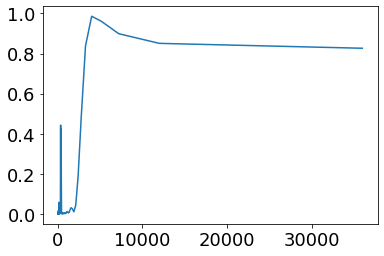

3998.8888888888896
330.18348623853217


In [4]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x_rv, y_rv).autopower()
period = 1/frequency


period_cut1 = period[period > 10]
power_cut1 = power[period > 10]

plt.plot(period_cut1, power_cut1) 
#plt.xlim(1000,10000)
plt.show()


indices = power_cut1.argsort()[-1:][::-1]
period1 = np.array(period_cut1[indices][0])
print(period1)

period1_min_cut = 2000
#period_cut1 > period1_min_cut so we don't double count

period_cut2 = period_cut1[period_cut1 < period1_min_cut]

power_cut2 = power_cut1[period_cut1 < period1_min_cut]


indices = power_cut2.argsort()[-1:][::-1]
period2 = period_cut2[indices][0]
print(period2)



minimizing RV only model solutions pre-MCMC
------------


optimizing logp for variables: [tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -262117.53789743647 -> -1171.2690027837193
optimizing logp for variables: [logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1171.2690027837193 -> -879.0735644701404
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -879.0735644701404 -> -750.7026350858832
optimizing logp for variables: [logs, ecs, logK, tperi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -750.7026350858832 -> -630.3304351513193


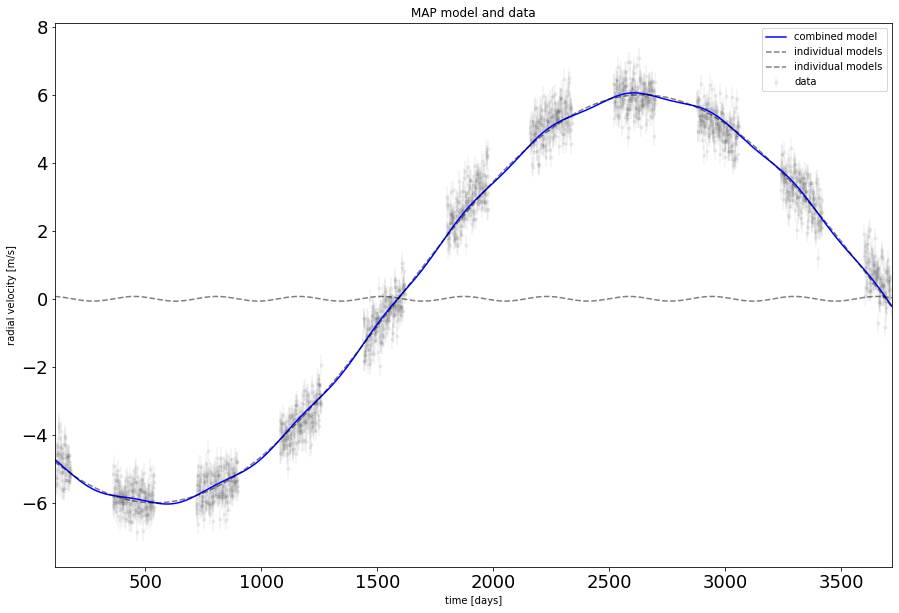

In [5]:

periods_guess = [period2, period1]
#periods_guess = [P_earth, P_jup]

Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()



In [ ]:
parallax = 0.1 # arcsec
model, map_soln, logp = model_both(
    rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
    ra_data, ra_err, dec_data, dec_err, parallax
)



RV Solutions
------------
P:  [ 355.77784731 4200.56990985]
K:  [0.06897824 5.99409123]
T_peri:  [ 725.72554127 3130.25331213]
eccentricity:  [1.10016366e-13 4.94273323e-07]
omega:  [-1.44767284  0.73154828]

minimizing joint model solutions pre-MCMC
------------

trying inclination = 10.0
------------


optimizing logp for variables: [Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -31736585.53460078 -> -11149622.401270207
optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -11149622.401270207 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -11149622.401270207 -> 414.64171317870955


log likelihood = 414.6300000000001

trying inclination = 45.0
------------


optimizing logp for variables: [Omega_plus, Omega_minus]


message: Optimization terminated successfully.
logp: -4981124.680516804 -> -501403.75099753815
optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -501403.75099753815 -> -21453.677030698487
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -21453.677030698487 -> 2528.8475311080792


log likelihood = 2528.8499999999995

trying inclination = 80.0
------------


optimizing logp for variables: [Omega_plus, Omega_minus]


message: Optimization terminated successfully.
logp: -4000787.062001454 -> -1586328.9423217042
optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -1586328.9423217042 -> -19773.869863102653


In [ ]:
print(logp)


In [ ]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r"$\Delta \alpha \cos \delta$ ['']")
ax[1].set_ylabel(r"$\Delta \alpha \cos \delta$ [''] residuals")
ax[2].set_ylabel(r"$\Delta \delta$ ['']")
ax[3].set_ylabel(r"$\Delta \delta$ [''] residuals")


tot_ra_err = np.sqrt(ra_err ** 2 + np.exp(2 * map_soln["log_ra_s"]))
tot_dec_err = np.sqrt(dec_err ** 2 + np.exp(2 * map_soln["log_dec_s"]))

ax[0].errorbar(x_astrometry, ra_data, yerr=tot_ra_err, **ekw)
ax[0].plot(t_fine, map_soln["ra_model_fine"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, ra_data - map_soln["ra_model"], yerr=tot_ra_err, **ekw
)


ax[2].plot(t_fine, map_soln["dec_model_fine"], color="#773f6a")
ax[2].errorbar(x_astrometry, dec_data, yerr=tot_dec_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, dec_data - map_soln["dec_model"], yerr=tot_dec_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

In [ ]:
fig, ax = plt.subplots(1, figsize = [9,9])
ax.plot(map_soln["ra_model_fine"], map_soln["dec_model_fine"], 
        color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
ax.plot(ra_data, dec_data, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = [15,10])

tot_rv_err = np.sqrt(y_rv_err ** 2 + np.exp(2 * map_soln["log_rv"]))

ax.errorbar(x_rv, y_rv, yerr=tot_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()

In [ ]:
print(map_soln['m_planet'])
print(map_soln['incl'])
print(map_soln['Omega'])
print(map_soln['tperi'])
print(map_soln['P'])
print(map_soln['ecc'])
print(map_soln['omega'])


In [ ]:
print([m_earth*m_sun, m_jup*m_sun])
print([inclination_earth, inclination_jup])
print([Omega_earth, Omega_jup])
print([Tper_earth, Tper_jup])
print([P_earth, P_jup])
print([e_earth, e_jup])
print([omega_earth, omega_jup])
